In [2]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import fsolve

from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
from os import listdir
from os.path import isfile, join

import sys
from tqdm import tqdm

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)


        Use get instead. [ligo.skymap.postprocess.cosmology]


In [3]:
def get_ename(fname, verbose=True):

        if len(fname.split('/')[-1].split('_')) <= 2:    #Same as before since certain names contain a "_"
            event_name = fname.split('/')[-1].split('_')[0]
        elif len(fname.split('/')[-1].split('_')) > 2:
            event_name = fname.split('/')[-1].split('_')[0]+'_'+fname.split('/')[-1].split('_')[1]
        else:
            raise ValueError('Could not set event name. Got fname= %s'%fname)
        if verbose:
            print('-- %s' %event_name)
        return event_name
    
def find_ra_dec(nside, pix):
        '''
        input:  pixel ra dec in degrees
        output: (ra, dec) of pixel center in degrees, with nside given by that of the skymap 
        '''
        theta, phi =find_theta_phi(nside,pix)
        ra, dec = ra_dec_from_th_phi(theta, phi)
        return ra, dec    
    
def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def find_theta_phi(nside, pix):
        '''
        input:  pixel
        output: (theta, phi)of pixel center in rad, with nside given by that of the skymap 
        '''
        return hp.pix2ang(nside, pix, nest=True)
    
def _read_O3( fname, convert_nested=True):
        
        skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        event_name = get_ename(fname, verbose=True)
        print('Event: %s' %event_name)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            p_posterior = hp.reorder(skymap[0],n2r=True)
            mu = hp.reorder(skymap[1],n2r=True)
            sigma = hp.reorder(skymap[2],n2r=True)
            posteriorNorm = hp.reorder(skymap[3],n2r=True)
            print('convertito da nested a ring')
        else:
            p_posterior= skymap[0]
            mu= skymap[1]
            sigma = skymap[2]
            posteriorNorm= skymap[3]        
        npix = len(p_posterior)
        nside=hp.npix2nside(npix)
        theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
        #print('Theta={}, Phi={}'.format(theta, phi))
        #ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
        #print('Right Ascension={}, Declination={}'.format(ra, dec))
        #print(metadata)
        #dl=metadata['distmean']
        #std=metadata['diststd']
        #z=cosmoglob.H(0).value*dl/clight
        #sigz=cosmoglob.H(0).value*std/clight
        #print('dL={}Mpc, std={}Mpc'.format(dl,std))
        #print('z={}, delta_z={}'.format(z,sigz))
        #print('\n')
        head = None
def z_from_dL(dL_GW_val):
    '''
    Returns redshift for a given luminosity distance dL_GW_val (in Mpc)
    
    Input:
        - dL_GW_val luminosity dist in Mpc
        - H0
        - Xi0: float. Value of Xi_0
        - n: float. Value of n

    '''   
    #print(cosmo.H0)
    func = lambda z : cosmoflag.luminosity_distance(z).value - dL_GW_val
    z = fsolve(func, 1)
    return z[0]

def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]

def mygaussint(prov_mu,prov_sigma,rho=1):
    first=np.exp(-(prov_mu**2)/(2*prov_sigma**2))*prov_mu*rho*prov_sigma/np.sqrt(2*np.pi)
    factor=0.5*rho*(prov_mu**2+prov_sigma**2)
    second=(1+scipy.special.erf(prov_mu/(np.sqrt(2)*prov_sigma)))
    ret=first+factor*second
    return ret

def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    meanvec=hp.ang2vec(mux,muy)
    meanvec=np.asarray(meanvec)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(x,y)
    var=np.asarray(var)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.dot(diff,diff))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    return ret

def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

In [4]:
#GWdata path
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/Hold_O3/'
os.chdir(GW_data_path)
#all_event=os.listdir()

  # Function to exploit, find how to localise an event and produce a proxy one. 
   def _read_O3(self, fname, convert_nested=True):
        
   skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True) #Read the skymap
        self.event_name = get_ename(fname, verbose=self.verbose)
        if self.verbose:
                print('\nEvent: %s' %self.event_name)
                #Raul: prints for control
                print('Delta=%s. If delta=1, normal run '%delta)
        if (convert_nested) & (metadata['nest']): #If one wants RING ordering (the one of O2 data afaik) just has to set "convert_nested" to True
            self.p_posterior = hp.reorder(skymap[0],n2r=True)
            self.mu = hp.reorder(skymap[1],n2r=True)
            self.sigma = hp.reorder(skymap[2],n2r=True)*delta
            self.posteriorNorm = hp.reorder(skymap[3],n2r=True)
        else:
            self.p_posterior= skymap[0]
            self.mu= skymap[1]
            self.sigma = skymap[2]*delta
            self.posteriorNorm= skymap[3]    

In [5]:
#Some files to look at 
filenames=['GW190814_PublicationSamples.fits',
           'GW190924_021846_PublicationSamples.fits',
           'GW190412_PublicationSamples.fits',
           'GW190915_235702_PublicationSamples.fits',
           'GW190708_232457_PublicationSamples.fits',
           'GW190421_213856_PublicationSamples.fits',
           'GW190527_092055_PublicationSamples.fits' 
           ]
########################## THIS GIVE US SOME INFO ######################################
#for name in filenames:
#    _read_O3(name)
########################################################################################
fname ='GW190814_PublicationSamples.fits'
alldl=[]
for fname in filenames:
    print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    nside=hp.npix2nside(npix)
    theta,phi=find_theta_phi(nside,np.argmax(p_posterior))
    ra, dec=find_ra_dec(nside,np.argmax(p_posterior))
    print('RA={},dec={},theta={},phi={}'.format(ra,dec,theta,phi))
    alldl.append(mu[np.argmax(p_posterior)])
    print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sig_avr=np.average(sigma,weights=p_posterior)
    print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
    print(len(p_posterior))
#alldl=np.asarray(alldl)
#print(np.mean(alldl))

GW190814_PublicationSamples.fits
RA=12.7001953125,dec=-24.87076339473571,theta=2.004873035517517,phi=0.22166022384947515
Dl=235.45665178530027
average luminosity distance Sigma=26.530261090991182 Mpc
12582912
GW190924_021846_PublicationSamples.fits
RA=127.265625,dec=16.25709623792208,theta=1.2870564706295728,phi=2.2212041808584084
Dl=499.3721200365884
average luminosity distance Sigma=134.49092733306685 Mpc
3145728
GW190412_PublicationSamples.fits
RA=218.4521484375,dec=36.42357364233115,theta=0.9350850413935945,phi=3.812709248289761
Dl=714.0899052030237
average luminosity distance Sigma=92.22291002240516 Mpc
12582912
GW190915_235702_PublicationSamples.fits
RA=195.46875,dec=37.26258031838149,theta=0.9204416124503026,phi=3.411573272257666
Dl=1591.1906291650755
average luminosity distance Sigma=422.8751010649481 Mpc
3145728
GW190708_232457_PublicationSamples.fits
RA=199.77272727272725,dec=65.69633519657744,theta=0.4241789711207841,phi=3.4866918465977625
Dl=867.5678481523114
average lumino

In [ ]:
my_theta,my_phi=hp.pix2ang(nside, np.argmax(p_posterior), nest=True)
vec = hp.ang2vec(my_theta, my_phi)
my_maxpix=hp.ang2pix(nside, my_theta, my_phi,nest=True)
maxpix=np.argmax(p_posterior)
print(maxpix,my_maxpix)

In [ ]:
print(vec)

In [ ]:
hp.mollview(p_posterior, title=fname,nest=True)

In [ ]:
credible_levels = find_greedy_credible_levels(p_posterior)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))

In [ ]:
_read_O3(fname)

In [ ]:
vec = hp.ang2vec(my_theta, my_phi)
ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=np.radians(circle_deg), nest=True)
ipix_90 = hp.query_disc(nside=nside, vec=vec, radius=np.radians(radius_deg), nest=True)
m =np.zeros(len(p_posterior))
m[ipix_disc] = 1/len(ipix_disc)
hp.mollview(m, title="Gaussian Mask",nest=True)

In [ ]:
Mock_Area_deg=len(ipix_disc) * hp.nside2pixarea(nside, degrees=True)
Mock_Area_90_deg=len(ipix_90) *hp.nside2pixarea(nside, degrees=True)
print('99.9999% area is {} squared deg\n90% area is {} squared deg'.format(Mock_Area_deg,Mock_Area_90_deg))

In [ ]:
'''
https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html(for ref on skymap)

Now we need to rescale the probability. We set the prob=0 ouside the circle
We assume that the renormalization is constant.
We crate a mask with our circle. Outside the mask p_posterior=0, the renormalization
constan alpha, is therefore 1/sum(p_posterior()). This ensure unitarity. 

If this works, than we will use a 2D Gaussian distribution for the probability

'''


In [ ]:
#saved_prob=np.zeros(len(p_posterior))
#saved_prob[ipix_disc]=p_posterior[ipix_disc]
#prob_to_write=np.zeros(len(p_posterior))
#alpha=1/np.sum(saved_prob)
#prob_to_write[ipix_disc]=alpha*saved_prob[ipix_disc]

In [ ]:
#print(np.sum(prob_to_write))

In [ ]:
#hp.mollview(prob_to_write, title="Mollview image NESTED",nest=True)

In [ ]:
#my_sky_tosave=(prob_to_write,skymap[1],sigma,posteriorNorm)
#my_sky_tosave=np.array([prob_to_write,mu,sigma,posteriorNorm])
#dat=Table([prob_to_write,mu,sigma,posteriorNorm],
#          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
#dat.write('Amap.fits',format='fits',overwrite=True)
#fits.write_sky_map('Amap.fits',dat, nest=True)

In [ ]:
#check result

In [ ]:
#my_data,my_meta=fits.read_sky_map("Amap.fits",nest=None, distances=True)
#print(my_meta)

In [ ]:
#hp.mollview(my_data[0], title="Mollview image NESTED",nest=True)

In [ ]:
#print(my_meta)

In [ ]:
#_read_O3('Amap.fits')

In [ ]:
temp_theta,temp_phi=find_theta_phi(nside,np.argmax(gaussmap))
temp_ra, temp_dec=find_ra_dec(nside,np.argmax(gaussmap))
print('GW221005 location: theta={}, phi={}, RA={}, DEC={}'.format(temp_theta,temp_phi,temp_ra,temp_dec))

In [ ]:
fname ='GW221900_PublicationSamples.fits'
my_data,my_meta=fits.read_sky_map(fname,nest=None, distances=True)

In [ ]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0
hp.mollview(my_prob, title=fname,nest=True)

In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.argmax(my_prob)
maxtheta,maxphi=hp.pix2ang(nside, 841536)
vicini=hp.get_all_neighbours(nside,maxtheta,maxphi)
print(maxtheta,maxphi)
print(vicini)

In [ ]:
for i in vicini:
    maxtheta,maxphi=hp.pix2ang(nside, i, nest=True)
    print(hp.get_all_neighbours(nside,maxtheta,maxphi,nest=True))

In [ ]:
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
    
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

In [ ]:
credible_levels = find_greedy_credible_levels(gaussmap)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


In [ ]:
my_theta,my_phi=find_theta_phi(nside,np.argmax(my_prob))
my_ra, my_dec=find_ra_dec(nside,np.argmax(my_prob))
print('GW location: theta={}, phi={}, RA={}, DEC={}'.format(my_theta,my_phi,my_ra,my_dec))
mu_avr=np.average(my_mu,weights=my_prob)
print('average luminosity distance={} Mpc'.format(mu_avr))
sig_avr=np.average(my_sigma,weights=my_prob)
print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
z_gw=z_from_dL(mu_avr)
print('redshift={}, in flagship cosmology'.format(z_gw))
comov=mu_avr/(1+z_gw)
print('comoving distance={}'.format(comov))

In [ ]:
np.sum(my_mu[0:3]*my_prob[0:3])

In [ ]:
len(my_mu)==len(my_prob)

# Automatic Map Creator 

z_min=0.7887375950813293, z_max=2.0129446983337402
ra_min=1.558116673550103e-05, ra_max=89.99999237060547
dec_min=2.9646462280652486e-06, dec_max=89.98294830322266
phi_min=2.7194266749575036e-07, phi_max=1.5707961320877075
theta_min=0.0002976218846182377, theta_max=1.570796275052059

In [5]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [8]:
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0001976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =5* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N)
#----------------------uniform in comoving DS-----------------------------
zlen=10
allredshift=np.zeros(zlen)
my_zmin=1.1
my_zmax=1.3
my_dcom_min=cosmoflag.comoving_distance(my_zmin).value
my_dcom_max=cosmoflag.comoving_distance(my_zmax).value
alldcom=np.linspace(my_dcom_min,my_dcom_max,zlen)
for i in range(zlen):
    allredshift[i]=z_from_dcom(alldcom[i])
#-------------------------------------------------------------------------
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start


truethetamin=theta_min+6*sigma_theta
truethetamax=theta_max-6*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M)
alltheta=np.arange(0,M)*step+truethetamin

print('N={},M={}, NxM={}'.format(N,M,N*M))


name='GW33xxxx_datasheet.txt'
file= open(name,'w')
my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
file.writelines(my_header)
file.close()

Fisher concentration Parameter k=4640.958140559668
Sigma_theta=0.014678989991133373, Sigma_phi=0.014678989991133373
Sigma_theta=0.84104417400672°, Sigma_phi=0.84104417400672°
0.07339494995566687 19
N=19,M=18, NxM=342


In [ ]:
testdcom=np.linspace(my_dcom_min,my_dcom_max*2,30)
testz=np.zeros(30)
for i in range(len(testdcom)):
    testz[i]=z_from_dcom(testdcom[i])
    
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#ax.set_yscale('log')
#ax.set_xscale('log')

ax.scatter(alldcom/1000,allredshift,label='dc-z',color=colors[3])
ax.scatter(testdcom/1000,testz,label='dc-z',color=colors[7])
ax.set_xlabel(r'$dc$', fontsize=20)
ax.set_ylabel(r'$z$', fontsize=20)

In [9]:
'''Use this when phi and theta both changes'''
for j in tqdm(range(M)):
    for k in range(N):
        numevent=int(320000)+k+j*N
        fname='GW'+str(numevent)+'_PublicationSamples.fits'
        index=k%zlen
        zref=allredshift[index]
        DS_phi=allphi[k]
        DS_theta=alltheta[j]
        vec = hp.ang2vec(DS_theta, DS_phi)
        ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
        #print(DS_theta,DS_phi)
        if fisher==1:
            gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
        else:
            gaussmap =np.zeros(len(p_posterior))
        mod_mu=np.zeros(len(p_posterior))
        mod_sigma=np.zeros(len(p_posterior))
        mod_postnorm=np.zeros(len(p_posterior))
        theta_arr=np.zeros(len(p_posterior))
        phi_arr=np.zeros(len(p_posterior))
        gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

        dlref=cosmoflag.luminosity_distance(zref).value
        dlsig=0.1*dlref
        #print(zref,dlref)
        line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
             str(dlsig)+'\t',str(sigma_phi)+'\n']

        for i in ipix_disc:
            theta,phi=hp.pix2ang(nside,i, nest=True)
            theta_arr[i]=theta
            phi_arr[i]=phi
            #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
            gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
            mod_mu[i]=dlref#uncorr_gauss(theta,phi)
            mod_sigma[i]=dlsig
            mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
        gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
        #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
        #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]
        
        gauss64=np.float64(gaussmap)
        dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
              names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
        fits.write_sky_map(fname,dat, nest=True)
        with open(name,'a') as f:
            f.writelines(line)

100%|███████████████████████████████████████████████████████████████| 18/18 [01:00<00:00,  3.39s/it]


In [ ]:
allredshift=np.linspace(1.1,1.3,10)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    #conc=4740
    #sigma_phi=np.sqrt(1/conc)
    #sigma_theta=sigma_phi
    radius_rad=np.radians(circle_deg)
for k in tqdm(range(10)):
    numevent=int(220000)+k
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=allredshift[k]
    #print(zref)
    DS_phi=np.pi/4
    DS_theta=np.pi/4
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))

    dlref=cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\n']
    
    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        #mod_postnorm[i]=1/(mygaussint(mod_mu[i],mod_sigma[i]))
    #gaussmap[ipix_disc] = 1/len(ipix_disc)
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=1/(len(ipix_disc))
    mod_postnorm[ipix_disc]=1
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)
    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
   # with open(name,'a') as f:
    #    f.writelines(line)

In [19]:
fname ='GW330025_PublicationSamples.fits'
my_data,my_meta=fits.read_sky_map(fname,nest=None, distances=True)

0.9999999999999999 1525.0


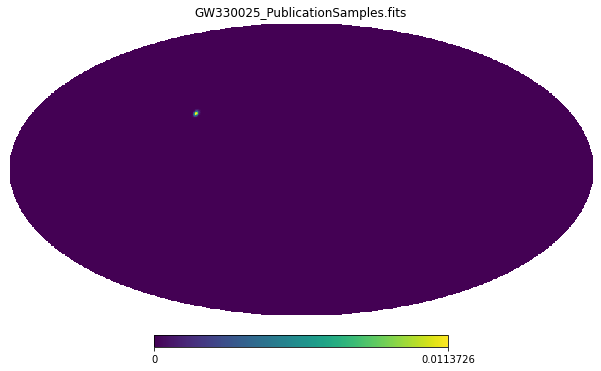

In [20]:
my_prob=my_data[0]
my_mu=my_data[1]
my_sigma=my_data[2]
my_norm=my_data[3]
npix = len(my_prob)
nside=hp.npix2nside(npix)
#my_mu[np.isinf(my_mu)]=0
print(np.sum(my_prob),(np.sum(my_norm)))
hp.mollview(my_prob, title=fname,nest=True)
#gaussmap00=my_prob

In [ ]:
fig = plt.subplots(1,figsize=(30,15))
#collection=gaussmap00*my_prob
#hp.cartview(collection,nest=True, hold=True)

In [21]:
credible_levels = find_greedy_credible_levels(my_prob)
Ligo_Area_99_deg=np.sum(credible_levels <= 0.99) * hp.nside2pixarea(nside, degrees=True)
Ligo_Area_90_deg=np.sum(credible_levels <= 0.9) * hp.nside2pixarea(nside, degrees=True)
print('Ligo area_deg 99% is {}\nLigo area_deg 90% is {} '.format(Ligo_Area_99_deg,Ligo_Area_90_deg))


Ligo area_deg 99% is 20.457782602022192
Ligo area_deg 90% is 10.228891301011096 


In [22]:
print('AngularProb')
if(np.isnan(my_prob).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isinf(my_prob).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")
    
print('Mu')
if(np.isnan(my_mu).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")
if(np.isinf(my_mu).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

print('DistNorm')
if(np.isnan(my_norm).any()):
    print("The Array contain NaN values")
else:
    print("The Array does not contain NaN values")

if(np.isinf(my_norm).any()):
    print("The Array contain inf values")
else:
    print("The Array does not contain inf values")

AngularProb
The Array does not contain NaN values
The Array does not contain inf values
Mu
The Array does not contain NaN values
The Array does not contain inf values
DistNorm
The Array does not contain NaN values
The Array does not contain inf values


# Generation by extraction from a Galaxy Catalogue

In [4]:
#----------------Load the catalogue---------------------
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
galcat = pd.read_csv('uniform_comoving_autoconsistent.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
galcat.columns=colnames
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)


In [6]:
#----------------------select random hosts ----------------------------------
zmin=1.1
zmax=1.3
Numb_of_DS=342
source=galcat[galcat['z']>=zmin]
source=source[source['z']<=zmax]
print(source.shape[0],source.shape[0]/galcat.shape[0])
source=source.sample(n=Numb_of_DS)
print(source.shape[0],source.shape[0]/galcat.shape[0])

#Best would be to remove the selected one, make them host and then add those again, 
#since we are converting coordinates
#pd.concat([df1, df2, df2]).drop_duplicates(keep=False)

DS_z=np.asarray(source['z'])
DS_dl=np.asarray(source['dl'])
DS_RA=np.asarray(source['right_ascension_degrees'])
DS_DEC=np.asarray(source['declination_degrees'])

phi_gals=np.deg2rad(DS_RA)
theta_gals = (0.5 * np.pi - np.deg2rad(DS_DEC))
#ra_gals=ra = np.rad2deg(phi_gals)
#dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

#checkRA=DS_RA-ra_gals
#chackDEC=DS_DEC-dec_gals
#print(checkRA)
#print(chackDEC)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)
#-------------------DATASHEET--------------------------------------
#name='GW35xxxx_datasheet.txt'
#file= open(name,'w')
#my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
#file.writelines(my_header)
#file.close()

1370955 0.21091615384615384
342 5.2615384615384616e-05
Fisher concentration Parameter k=4640.958140559668


In [54]:
#ztest=np.linspace(0.9,1.5,150)
#dltest=cosmoflag.luminosity_distance(ztest).value
    
#fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
#ax.tick_params(axis='both', which='major', labelsize=14)
#ax.yaxis.get_offset_text().set_fontsize(14)
#ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
#colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#ax.set_yscale('log')
#ax.set_xscale('log')

#ax.scatter(DS_z,DS_dl,label='catalog',color=colors[3])
#ax.plot(ztest,dltest,label='theo',color=colors[11])
#ax.set_xlabel(r'$z$', fontsize=20)
#ax.set_ylabel(r'$dl$', fontsize=20)

In [9]:
print(np.mean(DS_z),np.mean(DS_dl))

1.2065072052298285 8603.203346794842


In [55]:
#--------------------Maps Generations-------------------------------
'''Use this when phi and theta both changes'''
for i in tqdm(range(Numb_of_DS)):
    numevent=int(350000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=DS_z[i]
    DS_phi=phi_gals[i]
    DS_theta=theta_gals[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    else:
        gaussmap =np.zeros(len(p_posterior))
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

    dlref=DS_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    #print(zref,dlref)
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    with open(name,'a') as f:
        f.writelines(line)

100%|█████████████████████████████████████████████████████████████| 342/342 [01:01<00:00,  5.60it/s]


# Read Maps, Change sigma and/or Gauss displace
Those changes will not appear in the datasheet, so attention

In [59]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
all_files=os.listdir()
GWs=[]
for i in range(len(all_files)):
    if 'GW320' in all_files[i]:
        GWs.append(all_files[i])
GWs=list(dict.fromkeys(GWs))
del (all_files)
print(len(GWs))

342


In [60]:
for fname in tqdm(GWs):
    #print(fname)
    skymap, metadata = fits.read_sky_map(fname, nest=None, distances=True)
    p_posterior= skymap[0]
    mu= skymap[1]
    sigma = skymap[2]
    posteriorNorm= skymap[3]        
    npix = len(p_posterior)
    nside=hp.npix2nside(npix)
    #alldl.append(mu[np.argmax(p_posterior)])
    #print('Dl={}'.format(mu[np.argmax(p_posterior)]))
    sigma=mu*0.1
    sig=np.average(sigma,weights=p_posterior)
    dl=np.average(mu,weights=p_posterior)
    newdl=np.random.normal(dl,sig)
    scale=newdl/dl
    new_mu=scale*mu
    #new_sigma=new_mu*0.1
    #sig_avr=np.average(sigma,weights=p_posterior)
    #print('average luminosity distance Sigma={} Mpc'.format(sig_avr))
    #dat=Table([p_posterior,new_mu,sigma,posteriorNorm],
    #          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    #fits.write_sky_map(fname,dat, nest=True)

100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:16<00:00, 20.70it/s]


In [61]:
print(newdl)
print(sig)
print(dl)
print(scale)

9408.806287205822
918.9983055023276
9189.983055023275
1.023811059375451


# List Creator to config.py

In [19]:
names=[]

for i in range(350):
    numevent=int(360000)+i
    fname="'"+'GW'+str(numevent)+"'"
    names.append(fname)
    if (i % 29== 0)&(i>0):
        to_print=','.join(names)
        print('{}'.format(to_print))
        names=[]

'GW360000','GW360001','GW360002','GW360003','GW360004','GW360005','GW360006','GW360007','GW360008','GW360009','GW360010','GW360011','GW360012','GW360013','GW360014','GW360015','GW360016','GW360017','GW360018','GW360019','GW360020','GW360021','GW360022','GW360023','GW360024','GW360025','GW360026','GW360027','GW360028','GW360029'
'GW360030','GW360031','GW360032','GW360033','GW360034','GW360035','GW360036','GW360037','GW360038','GW360039','GW360040','GW360041','GW360042','GW360043','GW360044','GW360045','GW360046','GW360047','GW360048','GW360049','GW360050','GW360051','GW360052','GW360053','GW360054','GW360055','GW360056','GW360057','GW360058'
'GW360059','GW360060','GW360061','GW360062','GW360063','GW360064','GW360065','GW360066','GW360067','GW360068','GW360069','GW360070','GW360071','GW360072','GW360073','GW360074','GW360075','GW360076','GW360077','GW360078','GW360079','GW360080','GW360081','GW360082','GW360083','GW360084','GW360085','GW360086','GW360087'
'GW360088','GW360089','GW360090'

In [25]:
names=[]

for i in range(342):
    numevent=int(410000)+i
    fname="'"+'GW'+str(numevent)+"'"
    names.append(fname)
    to_print=','.join(names)
print('{}'.format(to_print))

'GW410000','GW410001','GW410002','GW410003','GW410004','GW410005','GW410006','GW410007','GW410008','GW410009','GW410010','GW410011','GW410012','GW410013','GW410014','GW410015','GW410016','GW410017','GW410018','GW410019','GW410020','GW410021','GW410022','GW410023','GW410024','GW410025','GW410026','GW410027','GW410028','GW410029','GW410030','GW410031','GW410032','GW410033','GW410034','GW410035','GW410036','GW410037','GW410038','GW410039','GW410040','GW410041','GW410042','GW410043','GW410044','GW410045','GW410046','GW410047','GW410048','GW410049','GW410050','GW410051','GW410052','GW410053','GW410054','GW410055','GW410056','GW410057','GW410058','GW410059','GW410060','GW410061','GW410062','GW410063','GW410064','GW410065','GW410066','GW410067','GW410068','GW410069','GW410070','GW410071','GW410072','GW410073','GW410074','GW410075','GW410076','GW410077','GW410078','GW410079','GW410080','GW410081','GW410082','GW410083','GW410084','GW410085','GW410086','GW410087','GW410088','GW410089','GW410090'

In [18]:
names=[]

for i in range(50):
    numevent=int(37)+i
    fname="'"+'GW'+str(numevent)+'0'+"'"
    names.append(fname)
    to_print=','.join(names)
print('{}'.format(to_print))

'GW370','GW380','GW390','GW400','GW410','GW420','GW430','GW440','GW450','GW460','GW470','GW480','GW490','GW500','GW510','GW520','GW530','GW540','GW550','GW560','GW570','GW580','GW590','GW600','GW610','GW620','GW630','GW640','GW650','GW660','GW670','GW680','GW690','GW700','GW710','GW720','GW730','GW740','GW750','GW760','GW770','GW780','GW790','GW800','GW810','GW820','GW830','GW840','GW850','GW860'


# Reset
those lines are used to reset the maps to the Datasheet state

In [ ]:
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)

In [62]:
#-------------------DATASHEET--------------------------------------
name='GW31xxxx_datasheet.txt'
#file= open(name,'w')
#my_header=['name\t','dl\t','theta\t','phi\t','z\t','deltadl\t','sigma_phi\n']
#file.writelines(my_header)
#file.close()
with open(name,'r') as f:
    next(f)
    lines=f.readlines()
    GWs_dl=[]
    GWs_theta=[]
    GWs_phi=[]
    GWs_z=[]
    GWs_deltadl=[]
    for x in lines:
        GWs_dl.append(float(x.split('\t')[1]))
        GWs_theta.append(float(x.split('\t')[2]))
        GWs_phi.append(float(x.split('\t')[3]))
        GWs_z.append(float(x.split('\t')[4]))
        GWs_deltadl.append(float(x.split('\t')[5]))
    #for i in range(len(GW_z)):

GWs_dl=np.asarray(GWs_dl)
GWs_theta=np.asarray(GWs_theta)
GWs_phi=np.asarray(GWs_phi)
GWs_z=np.asarray(GWs_z)
GWs_deltadl=np.asarray(GWs_deltadl)

In [63]:
for i in tqdm(range(len(GWs_dl))):
    numevent=int(310000)+i
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=GWs_z[i]
    DS_phi=GWs_phi[i]
    DS_theta=GWs_theta[i]
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    if fisher==1:
        gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    else:
        gaussmap =np.zeros(len(p_posterior))
     #-------------inizialising some arrays------------   
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)

    dlref=GWs_dl[i]#cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    #print(zref,dlref)
    #line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
    #     str(dlsig)+'\t',str(sigma_phi)+'\n']

    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=sphere_uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        mod_postnorm[i]=1#/(mygaussint(mod_mu[i],mod_sigma[i]))
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=mod_postnorm[ipix_disc]/(len(ipix_disc))
    #mod_postnorm[ipix_disc]=1/len(ipix_disc)#gaussmap[ipix_disc]

    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    fits.write_sky_map(fname,dat, nest=True)
    #with open(name,'a') as f:
    #    f.writelines(line)

100%|███████████████████████████████████████████████████████████████████████| 342/342 [01:19<00:00,  4.28it/s]


In [ ]:
fisher=1
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    radius_rad=np.radians(circle_deg)
else:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)

phi_min=0.0001
phi_max=1.5707961320877075
theta_min=0.0001976218846182377
theta_max=1.570796275052059
phi_start=phi_min+5*sigma_phi
phi_stop=phi_max-5*sigma_phi
step =5* sigma_phi
N=np.floor((phi_stop-phi_start)/step)
N=int(N)
#----------------------uniform in comoving DS-----------------------------
zlen=10
allredshift=np.zeros(zlen)
my_zmin=1.1
my_zmax=1.3
my_dcom_min=cosmoflag.comoving_distance(my_zmin).value
my_dcom_max=cosmoflag.comoving_distance(my_zmax).value
alldcom=np.linspace(my_dcom_min,my_dcom_max,zlen)
for i in range(zlen):
    allredshift[i]=z_from_dcom(alldcom[i])
#-------------------------------------------------------------------------
print('Sigma_theta={}, Sigma_phi={}'.format(sigma_theta,sigma_phi))
print('Sigma_theta={}°, Sigma_phi={}°'.format(np.rad2deg(sigma_theta)
                                              ,np.rad2deg(sigma_phi)))
print(step, N)
allphi=np.arange(0,N)*step+phi_start


truethetamin=theta_min+6*sigma_theta
truethetamax=theta_max-6*sigma_theta
M=np.floor((truethetamax-truethetamin)/step)
M=int(M)
alltheta=np.arange(0,M)*step+truethetamin


In [14]:
allredshift=np.linspace(1.1,1.3,10)
fisher=1
if fisher==1:
    radius_deg= np.sqrt(1000/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    #conc=100
    #sigma_phi=np.sqrt(1/conc)
    #sigma_theta=sigma_phi
    radius_rad=np.radians(circle_deg)
for k in tqdm(range(1)):
    numevent=int(220000)+k
    fname='GW'+str(numevent)+'_PublicationSamples.fits'
    zref=allredshift[k]
    #print(zref)
    DS_phi=np.pi/4
    DS_theta=np.pi/4
    vec = hp.ang2vec(DS_theta, DS_phi)
    ipix_disc = hp.query_disc(nside=nside, vec=vec, radius=radius_rad, nest=True)
    #print(DS_theta,DS_phi)
    gaussmap =np.zeros(len(p_posterior),dtype=np.float128)
    mod_mu=np.zeros(len(p_posterior))
    mod_sigma=np.zeros(len(p_posterior))
    mod_postnorm=np.zeros(len(p_posterior))
    theta_arr=np.zeros(len(p_posterior))
    phi_arr=np.zeros(len(p_posterior))

    dlref=cosmoflag.luminosity_distance(zref).value
    dlsig=0.01*dlref
    line=[str(numevent)+'\t',str(dlref)+'\t',str(DS_theta)+'\t',str(DS_phi)+'\t',str(zref)+'\t',
         str(dlsig)+'\n']
    
    for i in ipix_disc:
        theta,phi=hp.pix2ang(nside,i, nest=True)
        theta_arr[i]=theta
        phi_arr[i]=phi
        #gaussmap[i]=uncorr_gauss(theta,phi,DS_theta,DS_phi,sigma_theta,sigma_phi)*hp.nside2pixarea(nside,degrees=True)
        gaussmap[i]=np.float128(Mises_Fisher(theta,phi,DS_theta,DS_phi,conc))*np.float128(hp.nside2pixarea(nside,degrees=False))
        mod_mu[i]=dlref#uncorr_gauss(theta,phi)
        mod_sigma[i]=dlsig
        #mod_postnorm[i]=1/(mygaussint(mod_mu[i],mod_sigma[i]))
    #gaussmap[ipix_disc] = 1/len(ipix_disc)
    gaussmap[ipix_disc]=gaussmap[ipix_disc]/np.sum(gaussmap)
    #mod_postnorm[ipix_disc]=1/(len(ipix_disc))
    mod_postnorm[ipix_disc]=1
    gauss64 =np.zeros(len(p_posterior),dtype=np.float128)
    gauss64=np.float64(gaussmap)
    dat=Table([gauss64,mod_mu,mod_sigma,mod_postnorm],
          names=('PROB','DISTMU','DISTSIGMA','DISTNORM'))
    #fits.write_sky_map(fname,dat, nest=True)
   # with open(name,'a') as f:
    #    f.writelines(line)

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.81s/it]


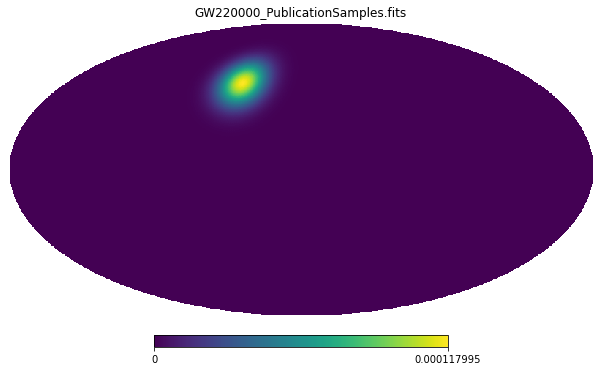

In [15]:
hp.mollview(gauss64, title=fname,nest=True)